# Proyecto Regrsion Lineal Demografica


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import os
from itertools import product
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_classif, SelectKBest, RFE
import joblib

In [3]:
# Cargamos el data set
ruta = r"/workspaces/aliasys-machine-probability/data/raw/demographic_health_data.csv"
df = pd.read_csv(ruta, sep=",")

In [4]:
df.head(5)

fips  TOT_POP    0-9  0-9 y/o % of total pop  19-Oct  \
0  1001    55601   6787               12.206615    7637   
1  1003   218022  24757               11.355276   26913   
2  1005    24881   2732               10.980266    2960   
3  1007    22400   2456               10.964286    2596   
4  1009    57840   7095               12.266598    7570   

   10-19 y/o % of total pop  20-29  20-29 y/o % of total pop  30-39  \
0                 13.735364   6878                 12.370281   7089   
1                 12.344167  23579                 10.814964  25213   
2                 11.896628   3268                 13.134520   3201   
3                 11.589286   3029                 13.522321   3113   
4                 13.087828   6742                 11.656293   6884   

   30-39 y/o % of total pop  ...  COPD_number  diabetes_prevalence  \
0                 12.749771  ...         3644                 12.9   
1                 11.564429  ...        14692                 12.0   
2                 12.865239  ...         2373                 19.7   
3                 13.897321  ...         1789                 14.1   
4                 11.901798  ...         4661                 13.5   

   diabetes_Lower 95% CI  diabetes_Upper 95% CI  diabetes_number  \
0                   11.9                   13.8             5462   
1                   11.0                   13.1            20520   
2                   18.6                   20.6             3870   
3                   13.2                   14.9             2511   
4                   12.6                   14.5             6017   

   CKD_prevalence  CKD_Lower 95% CI  CKD_Upper 95% CI  CKD_number  \
0             3.1               2.9               3.3        1326   
1             3.2               3.0               3.5        5479   
2             4.5               4.2               4.8         887   
3             3.3               3.1               3.6         595   
4             3.4               3.2               3.7        1507   

   Urban_rural_code  
0                 3  
1                 4  
2                 6  
3                 2  
4                 2  

[5 rows x 108 columns]

In [5]:
df.columns.tolist()

['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '19-Oct',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or 

## Observaciones:
 - Elegi la variable ['Obesity_prevalence'], pues tiene una prevalencia de la obesidad en la poblacion. Es muy util para estudiar factores asociados a la obesidad y condiciones de salud relacionadas.

In [6]:
df['Obesity_prevalence'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3140 entries, 0 to 3139
Series name: Obesity_prevalence
Non-Null Count  Dtype  
--------------  -----  
3140 non-null   float64
dtypes: float64(1)
memory usage: 24.7 KB


In [7]:
df['Obesity_prevalence'].describe()

count    3140.000000
mean       35.019299
std         4.517088
min        15.200000
25%        32.400000
50%        35.400000
75%        37.900000
max        49.900000
Name: Obesity_prevalence, dtype: float64

In [8]:
df['Obesity_prevalence'].isnull().sum()

np.int64(0)

 - Analizamos el EDA con la variable objetivo ['Obesity_prevalence']

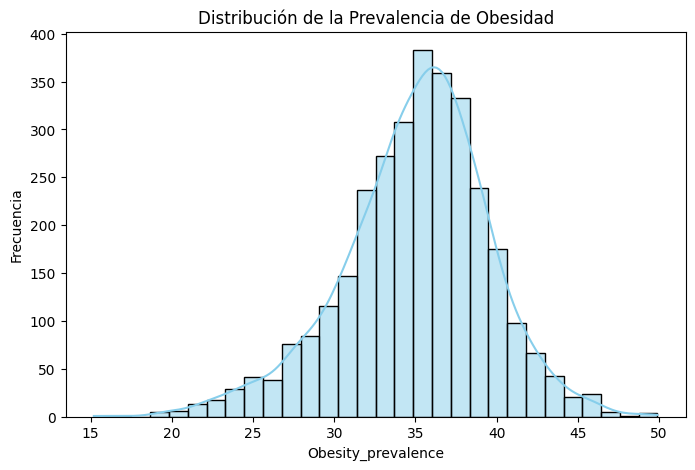

In [9]:
# Histograma
plt.figure(figsize=(8, 5))
sns.histplot(df['Obesity_prevalence'], kde=True, bins=30, color='skyblue')
plt.title('Distribución de la Prevalencia de Obesidad')
plt.xlabel('Obesity_prevalence')
plt.ylabel('Frecuencia')
plt.show()

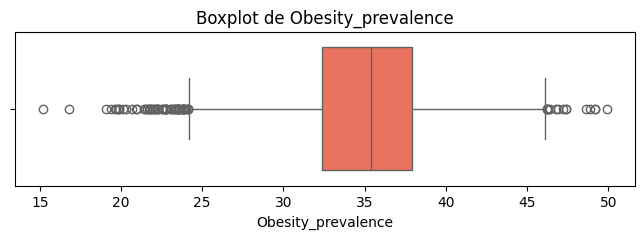

In [10]:
# Boxplot para identificar outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=df['Obesity_prevalence'], color='tomato')
plt.title('Boxplot de Obesity_prevalence')
plt.show()

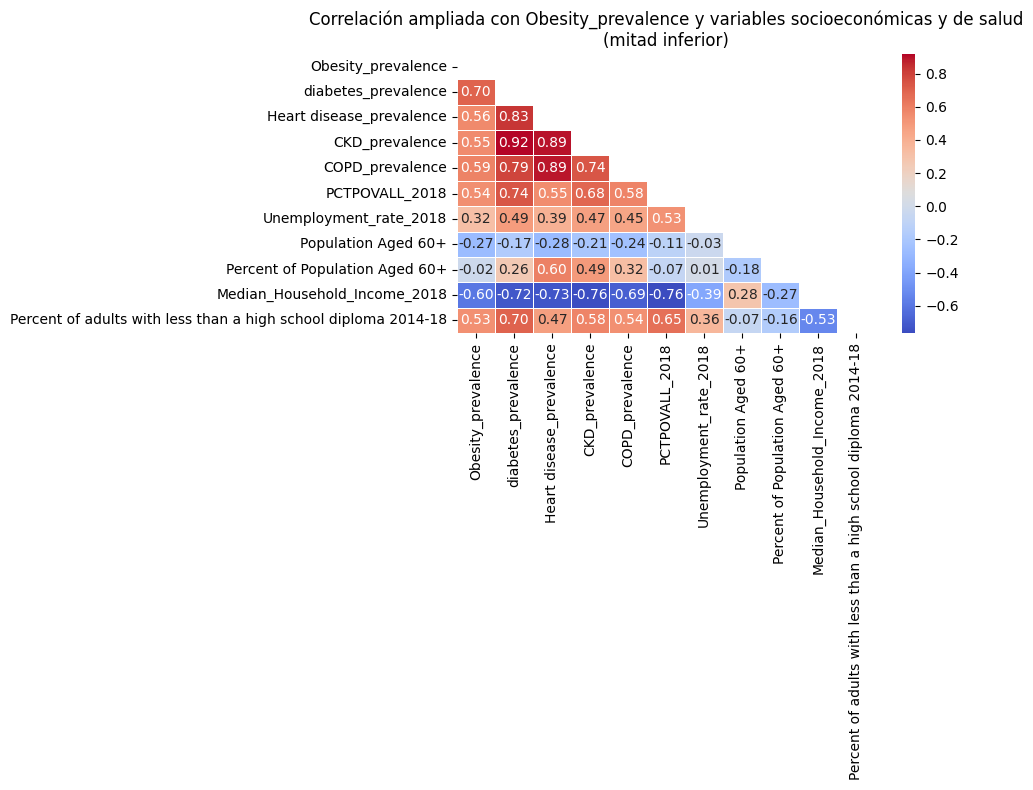

In [11]:
# Variables que quieres analizar con obesidad
extended_vars = [
    'Obesity_prevalence',
    'diabetes_prevalence',
    'Heart disease_prevalence',
    'CKD_prevalence',
    'COPD_prevalence',
    'PCTPOVALL_2018',
    'Unemployment_rate_2018',
    'Population Aged 60+',
    'Percent of Population Aged 60+',
    'Median_Household_Income_2018',
    'Percent of adults with less than a high school diploma 2014-18'
]

# Filtrar las que están en el dataframe
existing_extended_vars = [v for v in extended_vars if v in df.columns]

# Matriz de correlación para el subconjunto extendido
corr_extended = df[existing_extended_vars].corr()

# Máscara para ocultar triángulo superior
mask = np.triu(np.ones_like(corr_extended, dtype=bool))

# Heatmap con máscara
plt.figure(figsize=(10, 8))
sns.heatmap(corr_extended, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlación ampliada con Obesity_prevalence y variables socioeconómicas y de salud\n(mitad inferior)')
plt.tight_layout()
plt.show()


### Correlaciones positivas altas (relación directa)
- **Diabetes_prevalence (~ +0.83):**
  Existe una fuerte correlación positiva entre obesidad y diabetes, lo que indica que en regiones con mayor obesidad, también hay mayor prevalencia de diabetes. Esto es coherente con la evidencia médica que asocia obesidad con mayor riesgo de desarrollar diabetes tipo 2.

- **Heart disease_prevalence (~ +0.74):**
  También se observa una fuerte relación entre obesidad y enfermedades cardíacas. Esto refleja la carga que el exceso de peso impone al sistema cardiovascular.

- **CKD_prevalence y COPD_prevalence (~ +0.6 a +0.7):**
  La obesidad parece asociarse moderadamente con enfermedades crónicas como enfermedad renal crónica (CKD) y enfermedad pulmonar obstructiva crónica (COPD).

- **PCTPOVALL_2018 (Porcentaje de población en pobreza) (~ +0.52):**
  La obesidad se correlaciona positivamente con la pobreza. Esto podría explicarse por el acceso limitado a alimentos saludables y servicios médicos en comunidades con bajos ingresos.

### Correlaciones negativas (relación inversa)
- **Median_Household_Income_2018 (~ -0.45):**
  Se observa una correlación negativa moderada, lo que sugiere que los condados con mayores ingresos medios tienden a tener menor prevalencia de obesidad.

- **Percent of adults with less than a high school diploma (~ +0.5):**
  La obesidad aumenta a medida que el nivel educativo disminuye. Esta es una relación bien documentada: menor educación está asociada a menor conocimiento en salud y peores hábitos alimenticios.

- **Percent of Population Aged 60+ (~ -0.20):**
  Relación débilmente negativa: las zonas con mayor población adulta mayor no necesariamente tienen más obesidad. Es posible que las tasas bajen a edades avanzadas por pérdida de peso relacionada a la salud.

### Variables con correlación baja o neutra
- **Unemployment_rate_2018 (~ +0.1 a +0.2):**
  Se observa una correlación baja, indicando que el desempleo no tiene una relación clara o fuerte con la obesidad en este conjunto de datos.

## Conclusión

Esta matriz de correlación sugiere que la **prevalencia de obesidad está fuertemente asociada a enfermedades crónicas, pobreza y bajo nivel educativo**.
Estas correlaciones refuerzan la idea de que la obesidad es un fenómeno complejo influido por determinantes sociales y de salud.
Además, variables como el ingreso o la educación pueden actuar como factores protectores.

.

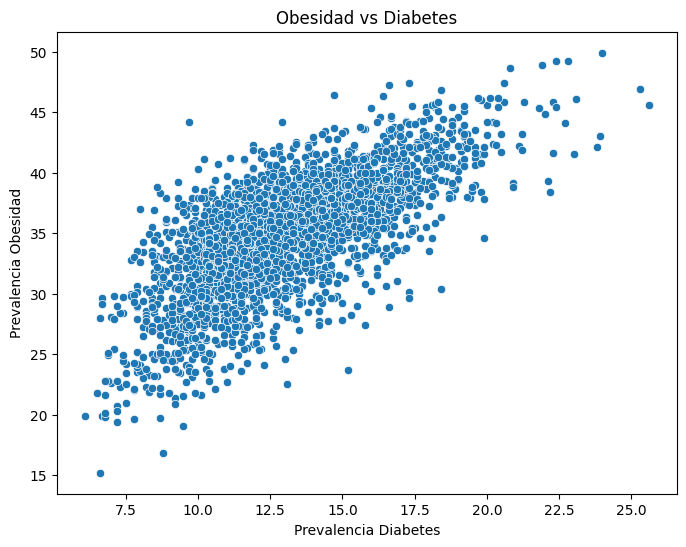

In [12]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='diabetes_prevalence', y='Obesity_prevalence')
plt.title('Obesidad vs Diabetes')
plt.xlabel('Prevalencia Diabetes')
plt.ylabel('Prevalencia Obesidad')
plt.show()

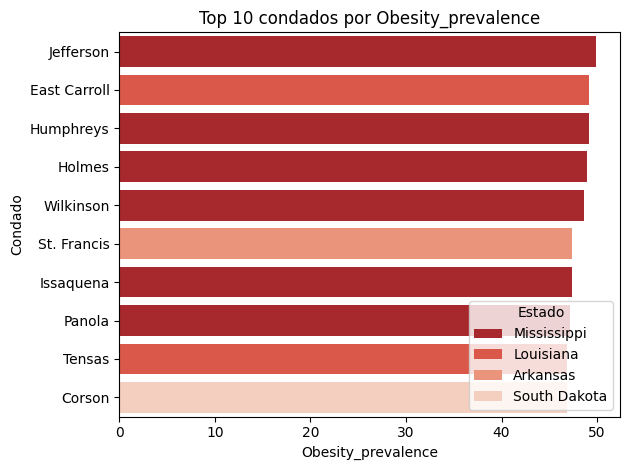

In [13]:
# Top 10 condados con mayor obesidad
top_counties = df[['STATE_NAME', 'COUNTY_NAME', 'Obesity_prevalence']].sort_values(
    by='Obesity_prevalence', ascending=False).head(10)

plt.figure()
sns.barplot(data=top_counties, y='COUNTY_NAME', x='Obesity_prevalence', hue='STATE_NAME', dodge=False, palette='Reds_r')
plt.title('Top 10 condados por Obesity_prevalence')
plt.xlabel('Obesity_prevalence')
plt.ylabel('Condado')
plt.legend(title='Estado', loc='lower right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_4042/2942019480.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_avg.values, y=state_avg.index, palette='Blues_r')


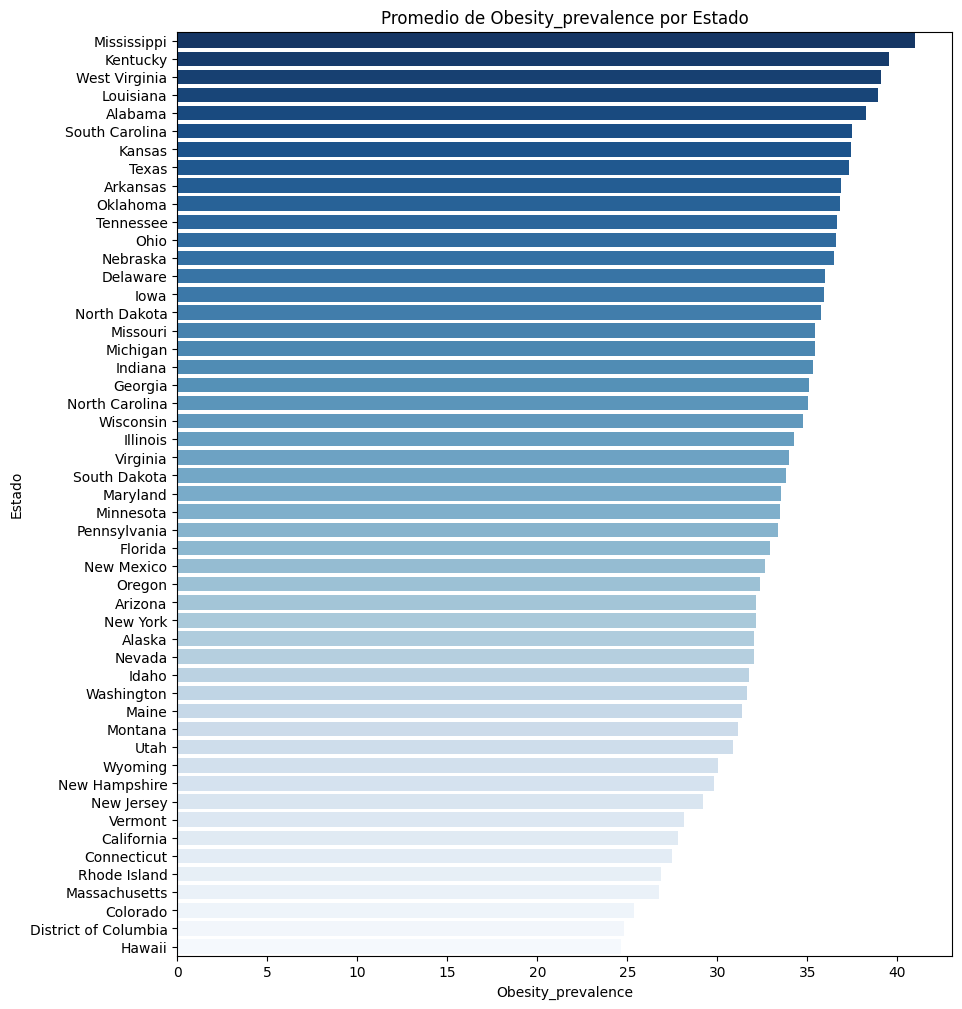

In [14]:
# Media de obesidad por estado
state_avg = df.groupby('STATE_NAME')['Obesity_prevalence'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x=state_avg.values, y=state_avg.index, palette='Blues_r')
plt.title('Promedio de Obesity_prevalence por Estado')
plt.xlabel('Obesity_prevalence')
plt.ylabel('Estado')
plt.show()

 - Analizamos los outliers

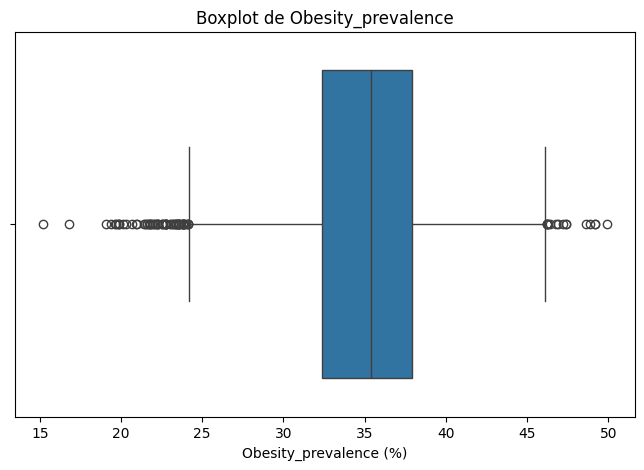

In [15]:

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Obesity_prevalence'])
plt.title('Boxplot de Obesity_prevalence')
plt.xlabel('Obesity_prevalence (%)')
plt.show()

In [16]:
Q1 = df['Obesity_prevalence'].quantile(0.25)
Q3 = df['Obesity_prevalence'].quantile(0.75)
IQR = Q3 - Q1

# Limites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Limite inferior: {lower_bound}')
print(f'Limite superior: {upper_bound}')

# Filtrar outliers
outliers = df[(df['Obesity_prevalence'] < lower_bound) | (df['Obesity_prevalence'] > upper_bound)]

print(f'Cantidad de outliers detectados: {len(outliers)}')
outliers[['Obesity_prevalence']].head()


Limite inferior: 24.15
Limite superior: 46.15
Cantidad de outliers detectados: 80


Obesity_prevalence
170                47.4
184                23.4
190                23.1
204                21.4
212                22.1

 - Visualizamos la distribucion ajustada

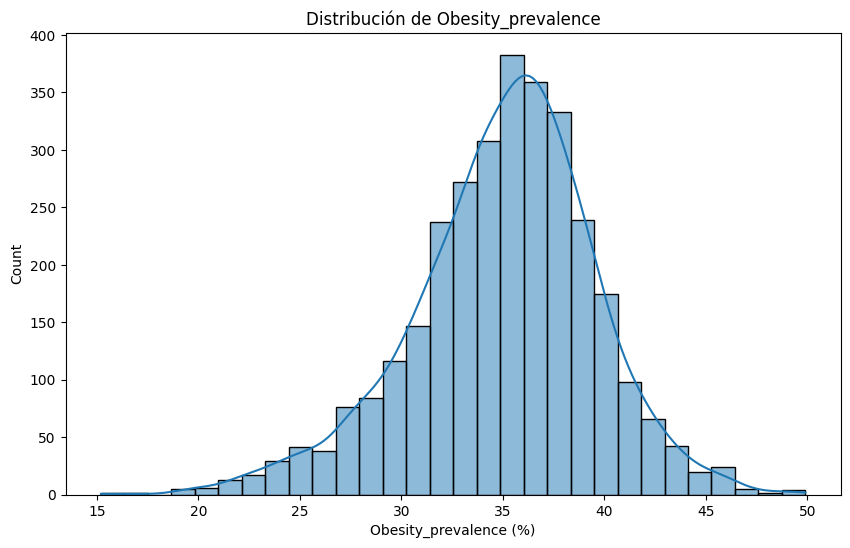

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(df['Obesity_prevalence'], bins=30, kde=True)
plt.title('Distribución de Obesity_prevalence')
plt.xlabel('Obesity_prevalence (%)')
plt.show()


### Escalado de valores

- Dividimos el conjunto en datos en muestras de train y test

In [18]:
# Variable objetivo
y = df['Obesity_prevalence']

# Variables predictoras (features), por ejemplo variables socioeconómicas y demográficas:
features = [
    'Median_Household_Income_2018',
    'PCTPOVALL_2018',
    'Unemployment_rate_2018',
    "Percent of adults with less than a high school diploma 2014-18",
    'diabetes_prevalence',
    'Heart disease_prevalence',
    # agrega las que quieras incluir
]

X = df[features]

# Eliminar filas con valores nulos (puedes optar por imputar en lugar de eliminar)
data = pd.concat([X, y], axis=1).dropna()

X = data[features]
y = data['Obesity_prevalence']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18
)

X_train.shape, X_test.shape

((2512, 6), (628, 6))

In [20]:
# Regresión Lineal básica
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [21]:
y_pred_lin = model.predict(X_test)
r2_lin = r2_score(y_test, y_pred_lin)
r2_lin

0.4882068402598263

In [22]:
# Modelo Lasso con alpha por defecto (1.0)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [23]:
y_pred_lasso = lasso_reg.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)
r2_lasso

0.4754223418188417

In [32]:
# Explorar R2 variando alpha en Lasso
r2_scores = []
alphas = np.linspace(0.0, 20, 100)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py:1363: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+04, tolerance: 5.147e+00
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_co

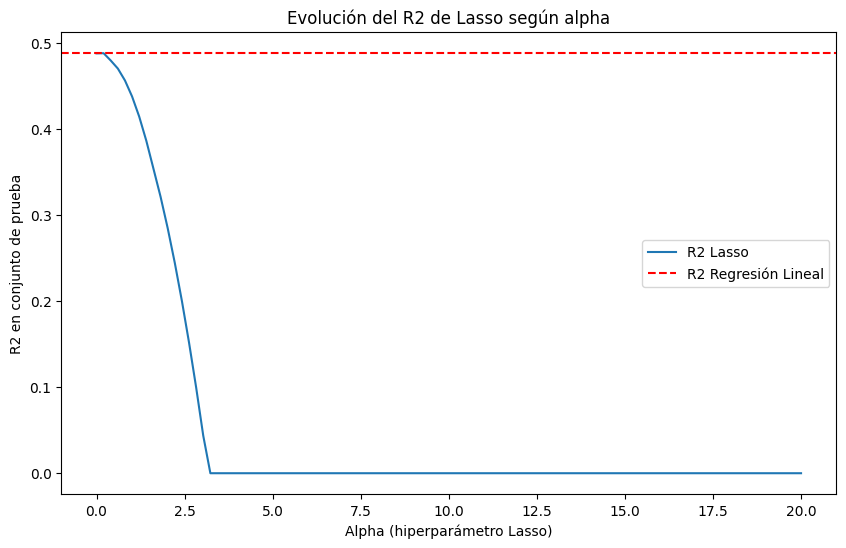

In [33]:
# Graficar R2 vs alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, r2_scores, label='R2 Lasso')
plt.axhline(r2_lin, color='red', linestyle='--', label='R2 Regresión Lineal')
plt.xlabel('Alpha (hiperparámetro Lasso)')
plt.ylabel('R2 en conjunto de prueba')
plt.title('Evolución del R2 de Lasso según alpha')
plt.legend()
plt.show()

## Interpretación

- Cuando **alpha es pequeño**, Lasso se comporta similar a la regresión lineal y ambos modelos tienen valores similares de R².
- Al aumentar **alpha**, Lasso penaliza más los coeficientes, simplificando el modelo al reducir algunos a cero.
- Esto puede mejorar la generalización si se evita el sobreajuste, pero también puede causar pérdida de información si la penalización es demasiado fuerte.
- El valor de alpha donde Lasso alcanza su **máximo R²** representa el mejor equilibrio entre sesgo y varianza.
- Si la curva de Lasso está **por encima** de la regresión lineal, indica que la regularización está mejorando el modelo.
- Si está **por debajo**, la regresión lineal simple es preferible para este problema.

## Conclusión

Esta gráfica nos dice si seleccionamos un alpha óptimo que maximice el rendimiento del modelo y decidimos si Lasso aporta mejoras sobre la regresión lineal clásica.

In [34]:
# Dividir X_train en entrenamiento y validación para tuning
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train,
                                                          y_train,
                                                          test_size=0.2,
                                                          random_state=18
)

In [35]:
# Escalar
scaler = StandardScaler()
X_train_sub_scaled = scaler.fit_transform(X_train_sub)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  # para usar después

In [36]:
# Buscar mejor alpha usando validación simple
alphas = np.linspace(0.01, 10, 100)
val_scores = []

for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_sub_scaled, y_train_sub)
    y_val_pred = model.predict(X_val_scaled)
    val_scores.append(r2_score(y_val, y_val_pred))

best_alpha = alphas[np.argmax(val_scores)]
print(f'Mejor alpha encontrado: {best_alpha}')
print(f'Mejor R2 en validación: {max(val_scores):.4f}')

Mejor alpha encontrado: 0.01
Mejor R2 en validación: 0.5316


In [37]:
# Entrenar con el mejor alpha en todo X_train y evaluar en test
scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train)
X_test_scaled_final = scaler_final.transform(X_test)

final_model = Lasso(alpha=best_alpha, max_iter=10000)
final_model.fit(X_train_scaled_final, y_train)
y_test_pred = final_model.predict(X_test_scaled_final)
r2_test = r2_score(y_test, y_test_pred)
print(f'R2 en test con mejor alpha: {r2_test:.4f}')

R2 en test con mejor alpha: 0.4905


### Observaciones:
> - Mejor alpha encontrado: 0.01:
>   - Esto es un valor muy bajo de regularización, casi sin penalización. Indica que la mejor versión del modelo Lasso es muy similar a una regresión lineal clásica, apenas reduciendo coeficientes.
> - Mejor R² en validación: 0.5316:
>   - En validación, el modelo explica un 53.16% de la varianza. Es un buen desempeño, ligeramente mejor que en test (49.05%), lo cual es esperado ya que validación se hizo con datos similares al entrenamiento.
> - R² en test: 0.4905:
>   - Un 49% de varianza explicada en datos nuevos. Esto sugiere que el modelo generaliza relativamente bien, sin sobreajuste fuerte.

## Guardamos todos los modelos y proyestos en su carpeta especifica

In [43]:
# Guardamos los archivos
ruta_base = r"/workspaces/aliasys-machine-probability/data/processed"

X_test.to_csv(f"{ruta_base}/X_test.csv", index=False)
pd.DataFrame(X_test_scaled).to_csv(f"{ruta_base}/X_test_scaled.csv", index=False)
pd.DataFrame(X_test_scaled_final).to_csv(f"{ruta_base}/X_test_scaled_final.csv", index=False)
X_train.to_csv(f"{ruta_base}/X_train.csv", index=False)
pd.DataFrame(X_train_scaled).to_csv(f"{ruta_base}/X_train_scaled.csv", index=False)
pd.DataFrame(X_train_scaled_final).to_csv(f"{ruta_base}/X_train_scaled_final.csv", index=False)
X_train_sub.to_csv(f"{ruta_base}/X_train_sub.csv", index=False)
pd.DataFrame(X_train_sub_scaled).to_csv(f"{ruta_base}/X_train_sub_scaled.csv", index=False)
y_test.to_csv(f"{ruta_base}/y_test.csv", index=False)
pd.DataFrame(y_test_pred).to_csv(f"{ruta_base}/y_test_pred.csv", index=False)
y_train.to_csv(f"{ruta_base}/y_train.csv", index=False)
y_train_sub.to_csv(f"{ruta_base}/y_train_sub.csv", index=False)

In [44]:
ruta_guardado = "/workspaces/aliasys-machine-probability/models"
# Guardar el modelo Lasso
joblib.dump(lasso, os.path.join(ruta_guardado, "modelo_lasso.pkl"))

# Guardar el escalador
joblib.dump(scaler, os.path.join(ruta_guardado, "scaler.pkl"))

['/workspaces/aliasys-machine-probability/models/scaler.pkl']